# Plant Seedlings Classification

### A simple notebook explaning step by step how to perform image classification using convolutional neural networks and keras

### The data for this notebook can be found at https://www.kaggle.com/c/plant-seedlings-classification

#### First things first, we are going to be working with train.zip and test.zip datasets. We will need to transform the datasets a bit in order to use keras, specifically we will initially split the train examples into 3 separate sets

* Train set (80% of the data)
* Validation set (10% of the data)
* Fake-test set (10% of the data)

Why the fake-test set? well, it will give us an opportunity to know for sure whether or not we have overfitted train and validation sets. 

In addition to that, we will also use the test set that will be directly sourced from the files in test.zip

IMPORTANT, when uncompressing the files, put them into a directory named ```raw```, you can simply uncompress it into a train directory and later rename it to ```raw```

So here's how the file structure looks like for the train.zip files.

```
├── Black-grass
│   ├── 129c51855.png
│   ├── a08892355.png
│   └── f84089a55.png
├── Charlock
│   ├── 0d5f555a3.png
│   ├── 20b955bc3.png
│   └── d9de67550.png
├── Cleavers
│   ├── 0f557bb1a.png
│   ├── 2559137f2.png
│   ├── d4552e3f6.png
│   └── d55caa949.png
├── Common Chickweed
│   ├── 34455bf75.png
│   ├── 4825503ed.png
│   ├── fa468d955.png
│   └── ffc02550b.png
├── Common wheat
│   ├── 554ec08a6.png
│   ├── 597d0557e.png
│   ├── a1f2c5550.png
│   └── b8525b55d.png
├── Fat Hen
│   ├── 066395555.png
│   ├── 08fe5538d.png
│   ├── e27bb5522.png
│   └── f3f6559bf.png
├── Loose Silky-bent
│   ├── 1f8562553.png
│   ├── 25c91550e.png
│   └── e55c8ded3.png
├── Maize
│   ├── 18b6755a1.png
│   ├── 55083690a.png
│   └── ff4b55219.png
├── Scentless Mayweed
│   ├── 025155400.png
│   ├── 126d55392.png
│   ├── 133553324.png
│   ├── e07e7b55b.png
│   └── fa55f4be4.png
├── Shepherds Purse
│   ├── 1022cc155.png
│   ├── 42556bc41.png
│   ├── 670b97558.png
│   └── f38565506.png
├── Small-flowered Cranesbill
│   ├── 04559c69c.png
│   ├── 055922489.png
│   ├── c9fa2e553.png
│   ├── f1196e55f.png
│   └── f46902555.png
└── Sugar beet
    ├── 5255463b3.png
    ├── 54f1ef55a.png
    ├── 5582aca59.png
    ├── d558ea002.png
    ├── f40d6554c.png
    └── ffa401155.png
```

So remember, we are going to be working with 12 classes, which are 

* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
* Sugar beet

The current data structure is not convenient, as we really need something like

```
train
    ├── Black-grass
    │   ├── 129c51855.png
    │   ├── a08892355.png
    │   └── f84089a55.png
    ├── Charlock
    │   ├── 0d5f555a3.png
    │   ├── 20b955bc3.png
    │   └── d9de67550.png
    ├── Cleavers
    ├── ... the rest of the classes 
    │
validation
    │
    ├── Black-grass
    │   ├── 1.png
    │   ├── 2.png
    │   └── 3.png
    ├── Charlock
    │   ├── 4.png
    │   ├── 5.png
    │   └── 6.png
    ├── Cleavers
    ├── ... the rest of the classes  
    |
fake-test
    |
    │
    ├── Black-grass
    │   ├── a.png
    │   ├── b.png
    │   └── c.png
    ├── Charlock
    │   ├── a.png
    │   ├── b.png
    │   └── c.png
    ├── Cleavers
    ├── ... the rest of the classes     
```

The reason we need such structure is because later we will make use of Kera's ImageGenerator object, which requires different dirs for train and validation sets.

So, first things, first, we are going to prepare our data

In [32]:
from os import listdir
from os import mkdir
from os import makedirs
import os
import shutil
from IPython.display import Image, display
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, vgg19
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.models import load_model
from keras import optimizers
import pandas as pd
from skimage import io
import numpy as np
import cv2

%matplotlib inline


In [2]:
# This code will require GPU usage... so sometimes we will need to run it in floydhub
FLOYDHUB=True
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    TRAIN_DIR = "/input/train/"
    VALIDATION_DIR = "/input/validation/"
    FAKE_TEST_DIR = "/input/fake-test"
    TEST_DIR = "/input/test"
else:
    OUTPUT_DIR = "/tmp/"
    TRAIN_DIR = "train/"
    VALIDATION_DIR = "validation/"
    FAKE_TEST_DIR = "fake-test/"
    TEST_DIR = "test/"

# As per the image size we will use, I am going with 224... no particular reason really
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


In [3]:
CLASS_NAMES = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet",
]

In [4]:
def prepare_data(train_size=0.8, validation_size=0.1, fake_test_size=0.1):
    """
    A simple code which will essentiall go into the "raw" directory and then read images from there and move 
    them into the TRAIN_DIR, VALIDATION_DIR and FAKE_TEST_DIR.
    """
    
    # First, lets create all the dirs we need.
    try:
        for class_name in CLASS_NAMES:
            makedirs(TRAIN_DIR+class_name, exist_ok=True)
            makedirs(VALIDATION_DIR+class_name, exist_ok=True)
            makedirs(FAKE_TEST_DIR+class_name, exist_ok=True)
    except Exception as e:
        print(e)
        pass
    
    # Now lets dive into each of the class directories of the "raw" directory
    for current_class in CLASS_NAMES:
        current_dir = "raw/"+current_class
        print("-----------------------------------")
        print("Now checking", current_dir)
        image_files = listdir(current_dir)
        total_files = len(image_files)
        index = 0
        total_images_train = 0
        total_images_validation = 0
        total_images_fake_test = 0
        
        for image_file in image_files:
            if index <= total_files * train_size: # This image will go to the train set
                total_images_train += 1
                shutil.copyfile(current_dir+"/"+image_file, TRAIN_DIR+current_class+"/"+image_file)
            elif index <= total_files * (train_size + validation_size): # This will go to the validation set
                total_images_validation += 1
                shutil.copyfile(current_dir+"/"+image_file, VALIDATION_DIR+current_class+"/"+image_file)
            else: # The rest will go to the fake test set
                total_images_fake_test +=1
                shutil.copyfile(current_dir+"/"+image_file, FAKE_TEST_DIR+current_class+"/"+image_file)
                
        
            index += 1
        
        print("There where a total of", total_files)
        print(total_images_train, "go to train set")
        print(total_images_validation, "go to validation set")
        print(total_images_fake_test, "go to the fake test set")

In [5]:
if FLOYDHUB == False:
    prepare_data()

### Lets show a couple of images...

/input/train/Black-grass/983663c56.png


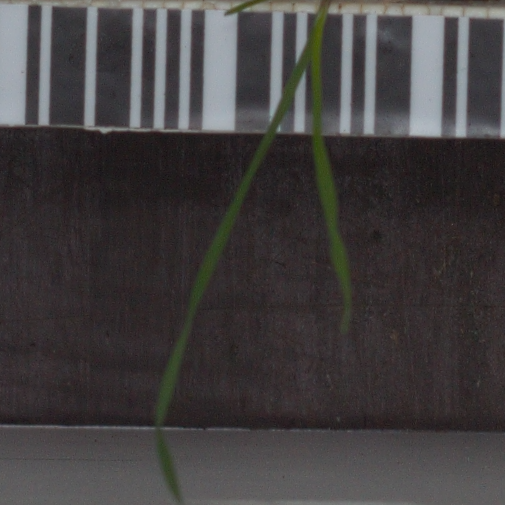

/input/train/Charlock/de0e95661.png


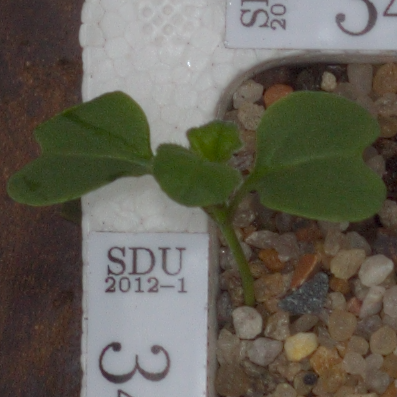

/input/train/Cleavers/9e966d9db.png


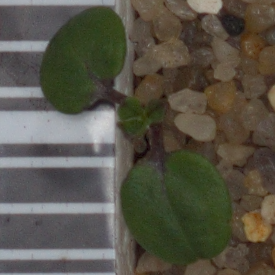

/input/train/Common Chickweed/cffd34ae2.png


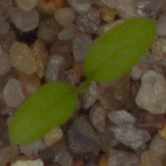

/input/train/Common wheat/12e0ffb23.png


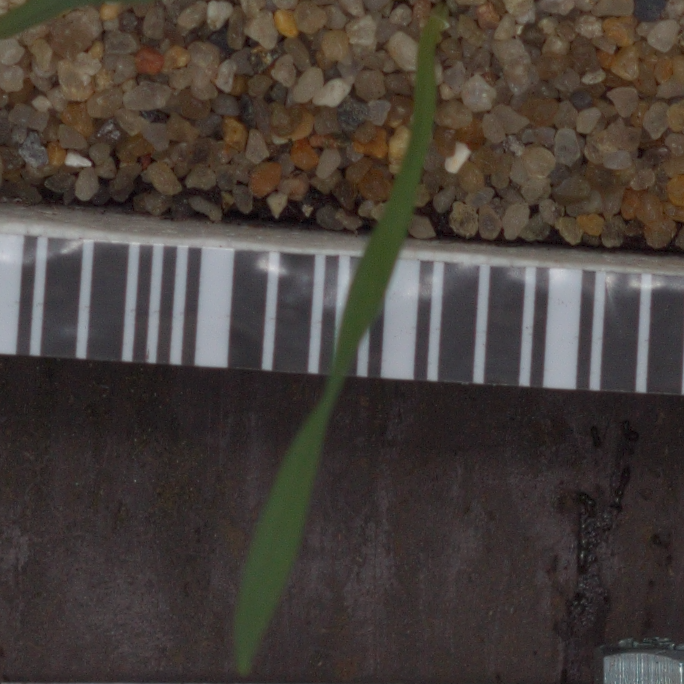

/input/train/Fat Hen/ac6625b0f.png


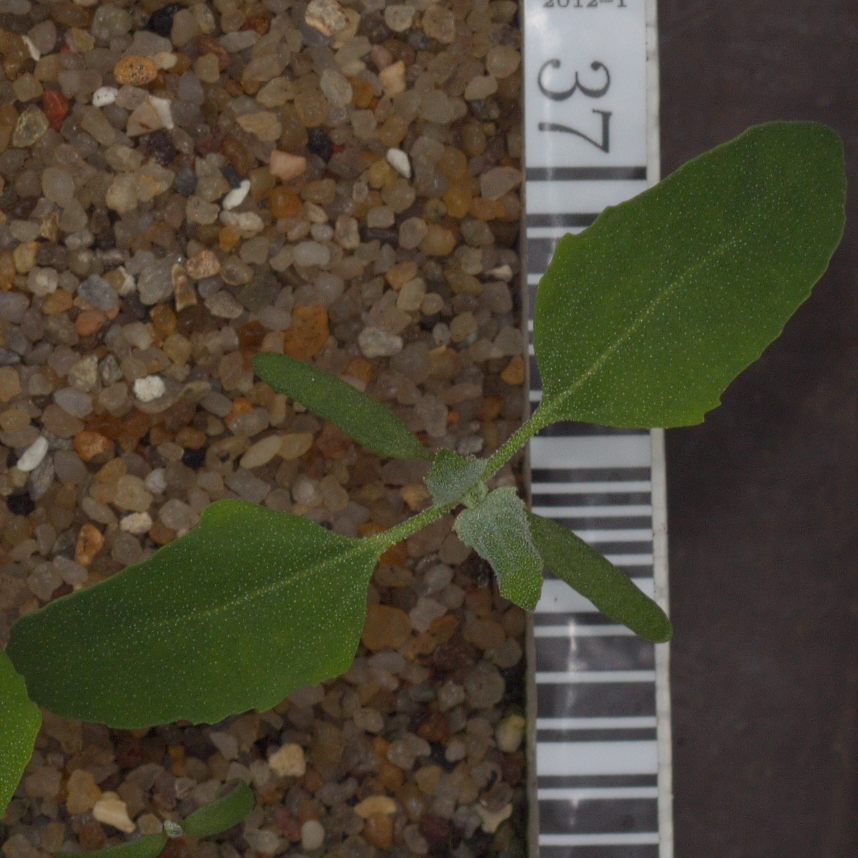

/input/train/Loose Silky-bent/b2b62db50.png


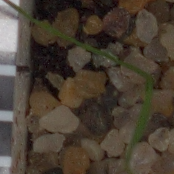

/input/train/Maize/006196e1c.png


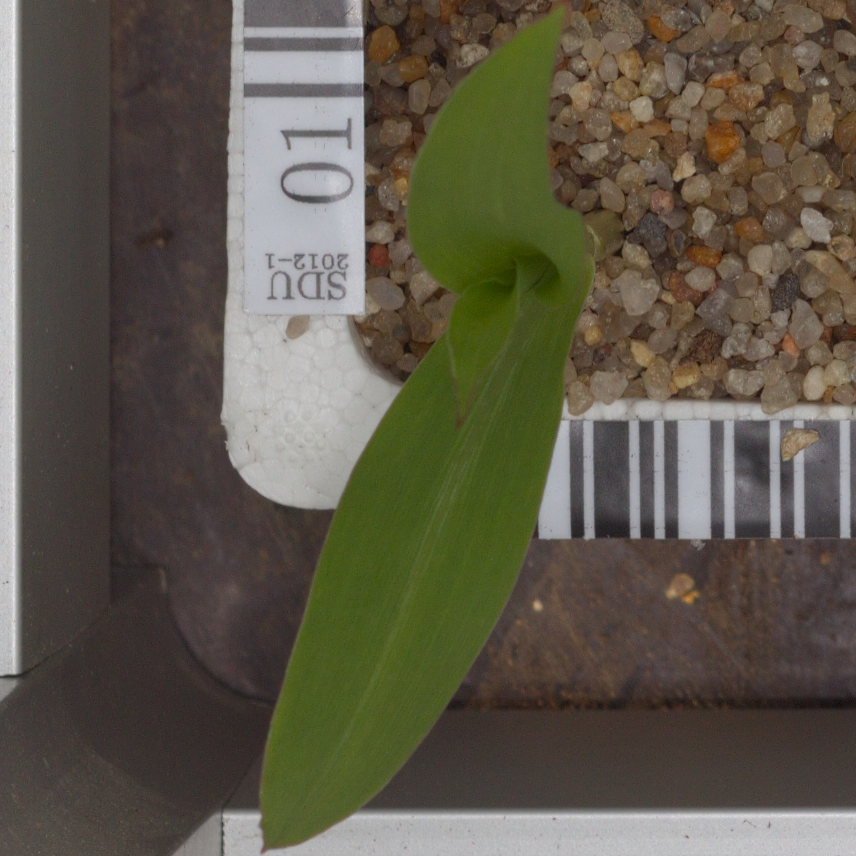

/input/train/Scentless Mayweed/3b87c72b8.png


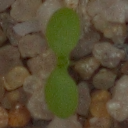

/input/train/Shepherds Purse/33010c8cb.png


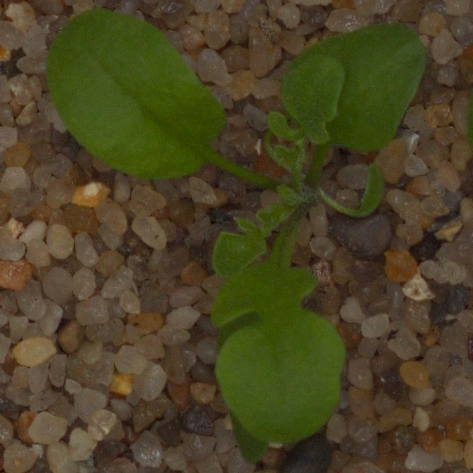

/input/train/Small-flowered Cranesbill/071907a13.png


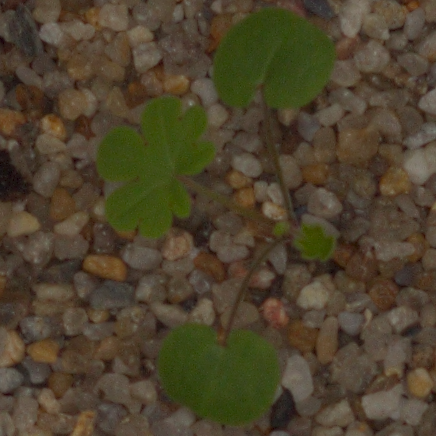

/input/train/Sugar beet/92be2b26d.png


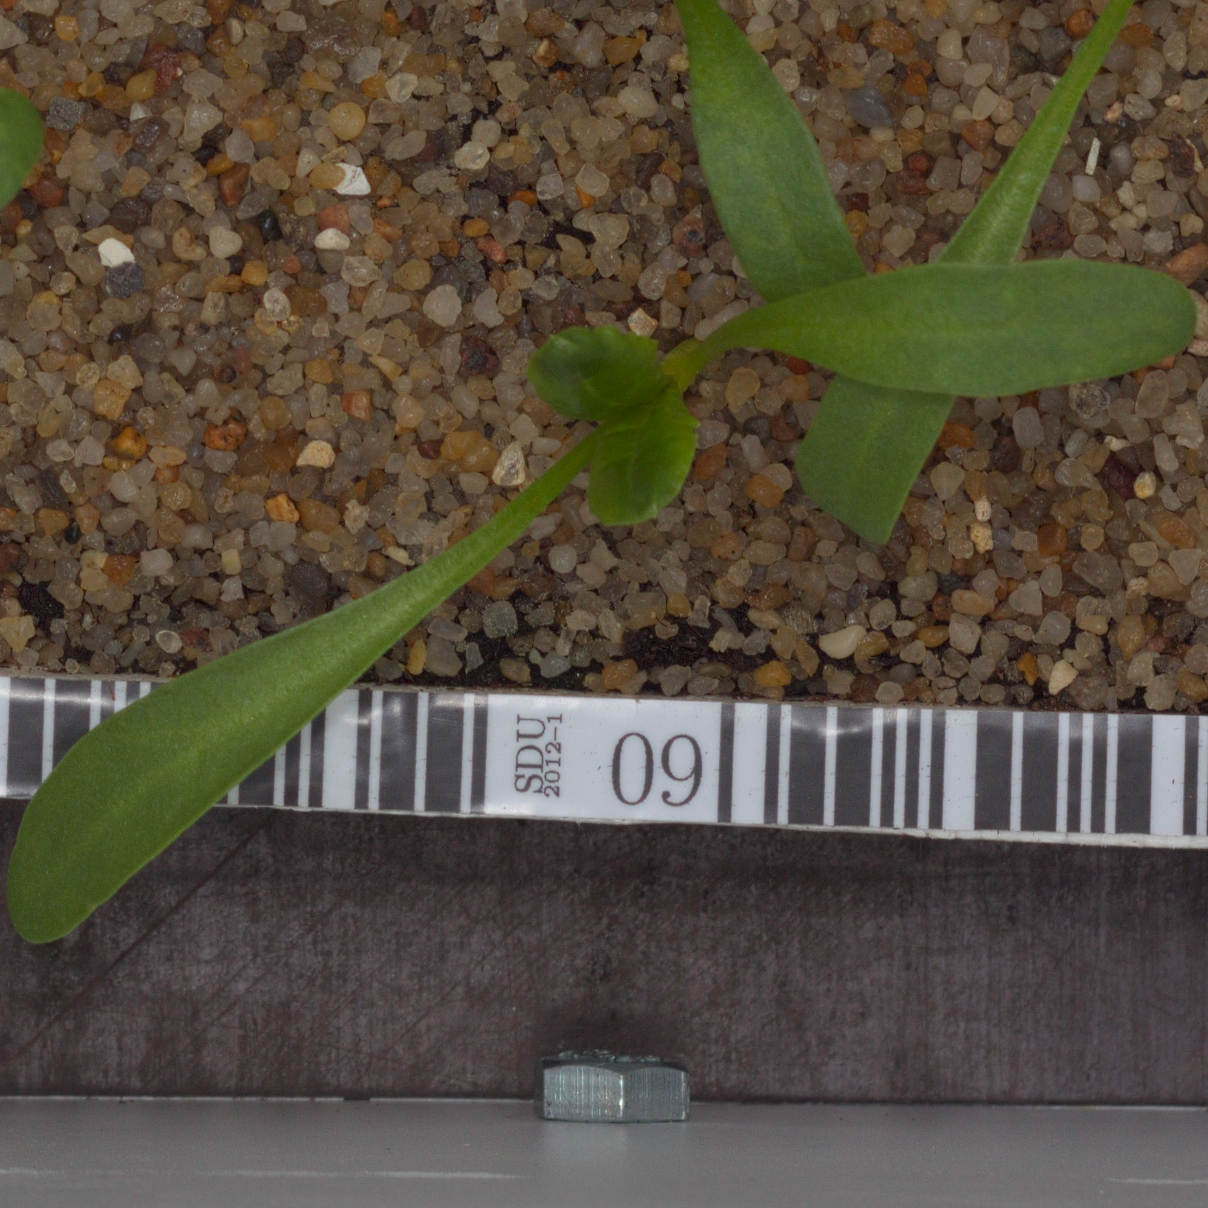

In [6]:
for my_class in CLASS_NAMES:
    current_dir = TRAIN_DIR+my_class
    for file in listdir(current_dir):
        image_file = TRAIN_DIR+my_class+"/"+file
        print(TRAIN_DIR+my_class+"/"+file)
        
        # Notice! The images have different sizes, so lets make sure we display them the same way...
        display(Image(filename=image_file, width=200, height=200))
        break


### As a fun note I will mention that so far all those pictures look very similar to me... I am pretty sure a farmer can easily tell the difference because he will have expertise in that area, but I do not. I wonder how good can machine learning get at this :) lets aim for 80% accuracy

### Lets get our ImageGenerator ready!

In [7]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# and the same for the test set
fake_test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we will need one-hot-encoded...

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

# And the generator for test data
fake_test_generator = fake_test_datagen.flow_from_directory(
        FAKE_TEST_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

Found 3806 images belonging to 12 classes.
Found 474 images belonging to 12 classes.
Found 470 images belonging to 12 classes.


In [8]:
training_samples = (3805 // batch_size ) * batch_size
validation_samples = (474 // batch_size ) * batch_size
fake_test_samples = (470 // batch_size ) * batch_size

In [ ]:
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)


In [ ]:
for layer in vgg16_model.layers:
        layer.trainable = False

In [ ]:
vgg16_model.summary()

In [ ]:
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x)

model = Model(input = vgg16_model.input, output = predictions)

In [ ]:
model.summary()

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [ ]:
model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator,
                                          steps_per_epoch=training_samples // batch_size,
                                          epochs=30,
                                          validation_data=validation_generator,
                                          validation_steps=validation_samples // batch_size)

In [ ]:
model.evaluate_generator(fake_test_generator)
model.save(OUTPUT_DIR + "vgg16.model")

### Prediction results for the fake test data

We have achieved a loss of 0.758 and an accuracy of 71.48%, quite similar to the ones in our train/validation sets, this indicates us that the model is not overfitting... that's good news.

After sending the predictions to kaggle the F1 score is 0.67254 which has landed me position 513 of 584... not really impressive at all... so lets keep digging here.

The next approach will consist on using a pretrained VGG16 model, but instead of freezing all the layers, we will actually train the last group of convolutions and pooling, lets try this!

In [ ]:
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()

#### Remember, we are going to make sure that we freeze all the layers of our model except the last ones

```
block5_conv1 (Conv2D)        (None, None, None, 512)   2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, None, None, 512)   2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, None, None, 512)   2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, None, None, 512)   0         
```

Which we will actually train... this will increase the training time but hopefully we will get better model

In [ ]:
for layer in vgg16_model.layers[0:-4]: # Remember, we will train the last 4 layers
    layer.trainable = False

In [ ]:
for layer in vgg16_model.layers:
    print(layer.name, "\t",  "trainable" if layer.trainable else "NOT trainable")

In [ ]:
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x)

model_trainable = Model(input = vgg16_model.input, output = predictions)

In [ ]:
model_trainable.summary()

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_trainable.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

history_trainable = model_trainable.fit_generator(train_generator,
                                                  steps_per_epoch=training_samples // batch_size,
                                                  epochs=30,
                                                  validation_data=validation_generator,
                                                  validation_steps=validation_samples // batch_size)

In [ ]:
model_trainable.evaluate_generator(fake_test_generator, steps= fake_test_samples // batch_size)

#### This is a great improvment

* Train set has an accuracy of 95.49%
* Validation has 86.03 %
* Fake test has 85.34%

Things have improved although we seem to be running into a bit of overfitting...

After sending this to kaggle I got an F1 score of 0.81486 which lands me in position 464 (before I was in position 513) out of a total of 584

As we are overfitting, the next step is to try the SAME model, but with better data augmentation

In [9]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen_audmented = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=0.5, # Consider removing...
        height_shift_range=0.5,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)



# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator_augmented = train_datagen_audmented.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we will need one-hot-encoded...


Found 3806 images belonging to 12 classes.


In [27]:
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)
for layer in vgg16_model.layers[:-8]: # Remember, we will train the last 4 layers
    layer.trainable = False
    
    
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x)

model_trainable = Model(input = vgg16_model.input, output = predictions)
    
    
for layer in vgg16_model.layers:
    print(layer.name, "\t",  "trainable" if layer.trainable else "NOT trainable")

input_9 	 NOT trainable
block1_conv1 	 NOT trainable
block1_conv2 	 NOT trainable
block1_pool 	 NOT trainable
block2_conv1 	 NOT trainable
block2_conv2 	 NOT trainable
block2_pool 	 NOT trainable
block3_conv1 	 NOT trainable
block3_conv2 	 NOT trainable
block3_conv3 	 NOT trainable
block3_pool 	 NOT trainable
block4_conv1 	 trainable
block4_conv2 	 trainable
block4_conv3 	 trainable
block4_pool 	 trainable
block5_conv1 	 trainable
block5_conv2 	 trainable
block5_conv3 	 trainable
block5_pool 	 trainable


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [28]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_trainable.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

history_trainable_augmented = model_trainable.fit_generator(train_generator_augmented,
                                                  steps_per_epoch=training_samples // batch_size,
                                                  epochs=30,
                                                  validation_data=validation_generator,
                                                  validation_steps=validation_samples // batch_size)

Epoch 1/30
237/237 [==============================] - 83s - loss: 2.4137 - acc: 0.1432 - val_loss: 2.2217 - val_acc: 0.2314
Epoch 2/30
237/237 [==============================] - 81s - loss: 2.0368 - acc: 0.3108 - val_loss: 1.4536 - val_acc: 0.4934
Epoch 3/30
237/237 [==============================] - 80s - loss: 1.4375 - acc: 0.5124 - val_loss: 1.3416 - val_acc: 0.5830
Epoch 4/30
237/237 [==============================] - 79s - loss: 1.0420 - acc: 0.6325 - val_loss: 0.8517 - val_acc: 0.7664
Epoch 5/30
237/237 [==============================] - 83s - loss: 0.8793 - acc: 0.6978 - val_loss: 0.5876 - val_acc: 0.8057
Epoch 6/30
237/237 [==============================] - 78s - loss: 0.6933 - acc: 0.7636 - val_loss: 0.5308 - val_acc: 0.8275
Epoch 7/30
237/237 [==============================] - 79s - loss: 0.5786 - acc: 0.8003 - val_loss: 0.3427 - val_acc: 0.8865
Epoch 8/30
237/237 [==============================] - 80s - loss: 0.5579 - acc: 0.8042 - val_loss: 0.4338 - val_acc: 0.8493
Epoch 9/

In [29]:
model_trainable.evaluate_generator(fake_test_generator, steps= fake_test_samples // batch_size)

[0.18144111922974215, 0.94396551724137934]

Kaggle gave me an F1 score of 0.93198 which positions me on place 319.

I am pretty sure that I can keep training the model and the results will improve!!


In [30]:
model_trainable.save("vgg16TrainableAugmented.model")

## Prediction area!

In [33]:
real_test_images = []
final_predictions = pd.DataFrame(columns=CLASS_NAMES)

image_files = listdir(TEST_DIR)
i = 0
for image_file in image_files:     
    raw_image = io.imread(TEST_DIR+"/"+image_file)
    scaled_img = cv2.resize(raw_image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
    real_test_images.append(scaled_img)
    i+=1    
    if i % 100 == 0:
        print("Loaded", i, "images so far...")
X = np.array(real_test_images)
X = X / 255
print("Done!") 

Loaded 100 images so far...
Loaded 200 images so far...
Loaded 300 images so far...
Loaded 400 images so far...
Loaded 500 images so far...
Loaded 600 images so far...
Loaded 700 images so far...
Done!


In [34]:
X.shape

(794, 224, 224, 3)

In [35]:
model_trainable = load_model("vgg16TrainableAugmented.model")

In [37]:
def predict_and_dump(model_to_use, X_to_use, image_files_to_use, file_name):
    results = model_to_use.predict(X_to_use, verbose=1)
    final_predictions = pd.DataFrame(columns=CLASS_NAMES, data=results)
    predictions = final_predictions.head().idxmax(axis=1)
    kaggle_data = pd.DataFrame(columns=["file"])
    kaggle_data["file"] = image_files_to_use
    kaggle_data["species"] = final_predictions.idxmax(axis=1)
    kaggle_data.to_csv(file_name, index=False)
    return kaggle_data, final_predictions


In [38]:
output, predictions_raw = predict_and_dump(model_trainable, X, image_files, "vgg16TrainablePredictions8Layers.csv")

794/794 [==============================] - 13s    


In [ ]:
output.head()

In [ ]:
predictions_raw.head()